Colegio de Matemáticas Bourbaki

Machine Learning & AI

In [1]:
!pip install --upgrade torch pytorch-lightning==1.9.4 pytorch-forecasting torchdata optuna numpy==1.24

Librerias

In [2]:
#Data Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch Lighting
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

#Pytorch Forcasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import  QuantileLoss
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

#Utils
import pickle
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

**NO TOCAR**

In [3]:
import copy
import logging
import os
from typing import Any, Dict, Tuple, Union

import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
import numpy as np
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import optuna.logging
import statsmodels.api as sm
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss

optuna_logger = logging.getLogger("optuna")


# need to inherit from callback for this to work
class PyTorchLightningPruningCallbackAdjusted(PyTorchLightningPruningCallback):
    pass


def optimize_hyperparameters(
    train_dataloaders: DataLoader,
    val_dataloaders: DataLoader,
    model_path: str,
    max_epochs: int = 20,
    n_trials: int = 100,
    timeout: float = 3600 * 8.0,  # 8 hours
    gradient_clip_val_range: Tuple[float, float] = (0.01, 100.0),
    hidden_size_range: Tuple[int, int] = (16, 265),
    hidden_continuous_size_range: Tuple[int, int] = (8, 64),
    attention_head_size_range: Tuple[int, int] = (1, 4),
    dropout_range: Tuple[float, float] = (0.1, 0.3),
    learning_rate_range: Tuple[float, float] = (1e-5, 1.0),
    use_learning_rate_finder: bool = True,
    trainer_kwargs: Dict[str, Any] = {},
    log_dir: str = "lightning_logs",
    study: optuna.Study = None,
    verbose: Union[int, bool] = None,
    pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
    **kwargs,
) -> optuna.Study:
    """
    Optimize Temporal Fusion Transformer hyperparameters.

    Run hyperparameter optimization. Learning rate for is determined with
    the PyTorch Lightning learning rate finder.

    Args:
        train_dataloaders (DataLoader): dataloader for training model
        val_dataloaders (DataLoader): dataloader for validating model
        model_path (str): folder to which model checkpoints are saved
        max_epochs (int, optional): Maximum number of epochs to run training. Defaults to 20.
        n_trials (int, optional): Number of hyperparameter trials to run. Defaults to 100.
        timeout (float, optional): Time in seconds after which training is stopped regardless of number of epochs
            or validation metric. Defaults to 3600*8.0.
        hidden_size_range (Tuple[int, int], optional): Minimum and maximum of ``hidden_size`` hyperparameter. Defaults
            to (16, 265).
        hidden_continuous_size_range (Tuple[int, int], optional):  Minimum and maximum of ``hidden_continuous_size``
            hyperparameter. Defaults to (8, 64).
        attention_head_size_range (Tuple[int, int], optional):  Minimum and maximum of ``attention_head_size``
            hyperparameter. Defaults to (1, 4).
        dropout_range (Tuple[float, float], optional):  Minimum and maximum of ``dropout`` hyperparameter. Defaults to
            (0.1, 0.3).
        learning_rate_range (Tuple[float, float], optional): Learning rate range. Defaults to (1e-5, 1.0).
        use_learning_rate_finder (bool): If to use learning rate finder or optimize as part of hyperparameters.
            Defaults to True.
        trainer_kwargs (Dict[str, Any], optional): Additional arguments to the
            `PyTorch Lightning trainer <https://pytorch-lightning.readthedocs.io/en/latest/trainer.html>`_ such
            as ``limit_train_batches``. Defaults to {}.
        log_dir (str, optional): Folder into which to log results for tensorboard. Defaults to "lightning_logs".
        study (optuna.Study, optional): study to resume. Will create new study by default.
        verbose (Union[int, bool]): level of verbosity.
            * None: no change in verbosity level (equivalent to verbose=1 by optuna-set default).
            * 0 or False: log only warnings.
            * 1 or True: log pruning events.
            * 2: optuna logging level at debug level.
            Defaults to None.
        pruner (optuna.pruners.BasePruner, optional): The optuna pruner to use.
            Defaults to optuna.pruners.SuccessiveHalvingPruner().

        **kwargs: Additional arguments for the :py:class:`~TemporalFusionTransformer`.

    Returns:
        optuna.Study: optuna study results
    """
    assert isinstance(train_dataloaders.dataset, TimeSeriesDataSet) and isinstance(
        val_dataloaders.dataset, TimeSeriesDataSet
    ), "dataloaders must be built from timeseriesdataset"

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)

    loss = kwargs.get(
        "loss", QuantileLoss()
    )  # need a deepcopy of loss as it will otherwise propagate from one trial to the next

    # create objective function
    def objective(trial: optuna.Trial) -> float:
        # Filenames for each trial must be made unique in order to access each checkpoint.
        checkpoint_callback = ModelCheckpoint(
            dirpath=os.path.join(model_path, "trial_{}".format(trial.number)), filename="{epoch}", monitor="val_loss"
        )

        learning_rate_callback = LearningRateMonitor()
        logger = TensorBoardLogger(log_dir, name="optuna", version=trial.number)
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        default_trainer_kwargs = dict(
            accelerator="auto",
            max_epochs=max_epochs,
            gradient_clip_val=gradient_clip_val,
            callbacks=[
                learning_rate_callback,
                checkpoint_callback,
                PyTorchLightningPruningCallbackAdjusted(trial, monitor="val_loss"),
            ],
            logger=logger,
            enable_progress_bar=optuna_verbose < optuna.logging.INFO,
            enable_model_summary=[False, True][optuna_verbose < optuna.logging.INFO],
        )
        default_trainer_kwargs.update(trainer_kwargs)
        trainer = pl.Trainer(
            **default_trainer_kwargs,
        )

        # create model
        hidden_size = trial.suggest_int("hidden_size", *hidden_size_range, log=True)
        kwargs["loss"] = copy.deepcopy(loss)
        model = TemporalFusionTransformer.from_dataset(
            train_dataloaders.dataset,
            dropout=trial.suggest_uniform("dropout", *dropout_range),
            hidden_size=hidden_size,
            hidden_continuous_size=trial.suggest_int(
                "hidden_continuous_size",
                hidden_continuous_size_range[0],
                min(hidden_continuous_size_range[1], hidden_size),
                log=True,
            ),
            attention_head_size=trial.suggest_int("attention_head_size", *attention_head_size_range),
            log_interval=-1,
            **kwargs,
        )
        # find good learning rate
        if use_learning_rate_finder:
            lr_trainer = pl.Trainer(
                gradient_clip_val=gradient_clip_val,
                accelerator="auto",
                logger=False,
                enable_progress_bar=False,
                enable_model_summary=False,
            )
            tuner = Tuner(lr_trainer)
            res = tuner.lr_find(
                model,
                train_dataloaders=train_dataloaders,
                val_dataloaders=val_dataloaders,
                early_stop_threshold=10000,
                min_lr=learning_rate_range[0],
                num_training=100,
                max_lr=learning_rate_range[1],
            )

            loss_finite = np.isfinite(res.results["loss"])
            if loss_finite.sum() > 3:  # at least 3 valid values required for learning rate finder
                lr_smoothed, loss_smoothed = sm.nonparametric.lowess(
                    np.asarray(res.results["loss"])[loss_finite],
                    np.asarray(res.results["lr"])[loss_finite],
                    frac=1.0 / 10.0,
                )[min(loss_finite.sum() - 3, 10) : -1].T
                optimal_idx = np.gradient(loss_smoothed).argmin()
                optimal_lr = lr_smoothed[optimal_idx]
            else:
                optimal_idx = np.asarray(res.results["loss"]).argmin()
                optimal_lr = res.results["lr"][optimal_idx]
            optuna_logger.info(f"Using learning rate of {optimal_lr:.3g}")
            # add learning rate artificially
            model.hparams.learning_rate = trial.suggest_uniform("learning_rate", optimal_lr, optimal_lr)
        else:
            model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)

        # fit
        trainer.fit(model, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders)

        # report result
        return trainer.callback_metrics["val_loss"].item()

    # setup optuna and run
    if study is None:
        study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study

**NO TOCAR**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


No vamos a explicar nuevamente el contexto del problema, iremos directamente a la solución del problema ya planteado. La primera parte del código es similar, por lo tanto, muchas celdas no serán descriptas.

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
device

device(type='cpu')

Pueden cambiar en Runtime->Change Runtime Type el dispositivo: https://research.google.com/colaboratory/faq.html#gpu-availability

Carga de Datos

In [7]:
df_x_train = pd.read_csv('./drive/MyDrive/Data/SNFC/Xtrain_hgcGIrA.csv')

In [8]:
index = df_x_train.index

In [9]:
df_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.8+ MB


In [10]:
df_train = df_x_train.copy(deep=True)
df_train.set_index('date', inplace=True)

In [11]:
y_train= pd.read_csv('./drive/MyDrive/Data/SNFC/Ytrain_yL5OjS4.csv')

In [12]:
df = y_train[['p0q0']]
df = df.set_index(df_train.index, drop=True)

In [13]:
df_x_train

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN


In [14]:
df_train['train'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54, 55,
        6,  7,  8,  9])

In [15]:
df_train['train'].nunique()

55

In [16]:
datos = pd.concat([y_train, df_x_train], axis=1)

In [17]:
datos

,Unnamed: 0,p0q0,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,1,0.216,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
1,2,0.216,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2,3,0.227,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
3,4,0.229,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
4,5,0.225,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,31115,0.111,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
31115,31116,0.143,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
31116,31117,0.139,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN
31117,31118,0.117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN


In [18]:
datos = datos.drop('Unnamed: 0', axis=1)
datos = datos.dropna()

In [19]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17666 entries, 116 to 31001
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   p0q0         17666 non-null  float64
 1   date         17666 non-null  object 
 2   train        17666 non-null  int64  
 3   way          17666 non-null  int64  
 4   station      17666 non-null  object 
 5   hour         17666 non-null  object 
 6   composition  17666 non-null  int64  
 7   p1q0         17666 non-null  float64
 8   p2q0         17666 non-null  float64
 9   p3q0         17666 non-null  float64
 10  p0q1         17666 non-null  float64
 11  p0q2         17666 non-null  float64
 12  p0q3         17666 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 1.9+ MB


In [20]:
datos['hour'] = datos['hour'].astype(str)  # Convert all values to strings
datos['hour'] = datos['hour'].apply(lambda x: float(x[:2]))

In [21]:
datos.sort_values(by='date', inplace = True)
datos = datos.reset_index(drop=True)

Veamos cuántas fechas únicas tenemos:

In [22]:
lista = datos['date'].unique()

In [23]:
len(lista)

74

Vamos a crear una nueva columna llamada time_idx donde aisgnaremos cada fila en datos un índice basado en la posición de su valor de fecha (date) dentro dela variable de una lista (lista).

In [24]:
datos['time_idx'] = [np.where(lista == datos.loc[i,'date'])[0][0] for i in range(datos.shape[0])]

In [25]:
datos

,p0q0,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,time_idx
0,0.282,2019-01-07,1,0,AJ,6.0,2,0.149000,0.1830,0.168000,0.216,0.275,0.230,0
1,0.256,2019-01-07,24,0,BC,7.0,2,0.056000,0.0410,0.260320,0.145,0.196,0.213,0
2,0.375,2019-01-07,24,0,AQ,7.0,2,0.280000,0.1890,0.333667,0.325,0.285,0.334,0
3,0.307,2019-01-07,24,0,AO,7.0,2,0.073000,0.0580,0.291550,0.256,0.196,0.213,0
4,0.334,2019-01-07,24,0,AL,7.0,2,0.088000,0.0740,0.312080,0.307,0.256,0.213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17661,0.427,2019-05-20,10,0,AM,8.0,2,0.397000,0.3804,0.327800,0.285,0.217,0.162,73
17662,0.240,2019-05-20,14,0,AQ,7.0,2,0.269000,0.1770,0.292000,0.140,0.205,0.092,73
17663,0.292,2019-05-20,30,0,AQ,7.0,2,0.177000,0.2690,0.177000,0.247,0.221,0.041,73
17664,0.092,2019-05-20,28,0,AK,7.0,2,0.285056,0.0560,0.189000,0.076,0.064,0.050,73


Comenzaremos a utilizar Pytorch Forecasting para resolver nuestro problema:

El siguiente paso es convertir el marco de datos en un PyTorch Forecasting TimeSeriesDataSet. Aparte de indicar al conjunto de datos qué características son categóricas frente a continuas y cuáles son estáticas frente a variables en el tiempo, también tenemos que decidir cómo normalizamos los datos. Aquí, normalizamos la escala de cada serie temporal por separado e indicamos que los valores son siempre positivos. Generalmente, se prefiere el EncoderNormalizer, que escala dinámicamente en cada secuencia del codificador a medida que se entrena, para evitar el sesgo look-ahead inducido por la normalización. Sin embargo, puede aceptar el sesgo de anticipación si tiene problemas para encontrar una normalización razonablemente estable, por ejemplo, porque hay muchos ceros en sus datos. O si espera una normalización más estable en la inferencia. En este último caso, se asegura de que no aprende saltos "raros" que no estarán presentes cuando ejecute la inferencia, entrenando así en un conjunto de datos más realista.

In [26]:
max_prediction_length = 30
max_encoder_length = 60
training_cutoff = datos["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    datos[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target='p0q0',
    group_ids=["train", 'station'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['station'],
    static_reals=['composition'],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=['p0q1','p0q2','p0q3','p1q0','p2q0','p3q0','hour'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
    ],
    target_normalizer=GroupNormalizer(
        groups=[], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, datos, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

Aquí estamos configurando un conjunto de datos para entrenar y validar un modelo de series temporales utilizando la biblioteca pytorch-forecasting, que es popular para tareas de predicción en series temporales con PyTorch.

A continuación, se detalla paso a paso lo que se está realizando:

  * Definición de Parámetros: Se establecen dos parámetros, max_prediction_length y max_encoder_length, que definen respectivamente la longitud máxima de la predicción y la longitud máxima del codificador (historia o contexto utilizado para la predicción).

  * Cálculo del Punto de Corte para el Entrenamiento: Se calcula training_cutoff para determinar hasta qué punto en el tiempo se incluirán los datos en el conjunto de entrenamiento. Esto se hace para asegurar que haya suficientes datos hacia el final del conjunto de datos para validar el modelo.

  * Creación del Conjunto de Datos para Entrenamiento (TimeSeriesDataSet):
      Se filtran los datos para incluir solo aquellos puntos en el tiempo que son iguales o anteriores al training_cutoff.
      Se especifican varias configuraciones importantes para el conjunto de datos, como los índices de tiempo (time_idx), la variable objetivo (target), los identificadores de grupo (group_ids), las longitudes mínima y máxima del codificador, y la longitud de la predicción.
      Se definen configuraciones adicionales como categorías estáticas y reales, variables conocidas y desconocidas tanto categóricas como reales, y se establece un normalizador de grupo para la variable objetivo.
      Se añaden características adicionales como el índice de tiempo relativo, las escalas del objetivo y la longitud del codificador.

  * Creación del Conjunto de Datos para Validación (TimeSeriesDataSet.from_dataset):
      Se crea un conjunto de datos para validación a partir del conjunto de entrenamiento, utilizando la totalidad de los datos pero configurando el conjunto para predecir los últimos max_prediction_length puntos para cada serie temporal.
      Esto permite evaluar cómo el modelo predice los datos "futuros" basándose en el conocimiento "pasado".

  * Creación de DataLoader para Entrenamiento y Validación:
      Se crean DataLoader para ambos conjuntos, permitiendo la carga eficiente de datos durante el entrenamiento y la validación del modelo en mini-lotes de tamaño batch_size.

Este proceso es típico en la preparación de datos para el entrenamiento de modelos de series temporales, permitiendo un manejo eficiente de diferentes longitudes de series, incorporación de variables explicativas y ajuste de parámetros específicos para la predicción temporal. La biblioteca pytorch-forecasting facilita la manipulación de series temporales complejas y la implementación de modelos de deep learning para su predicción.

Para determinar el valor adecuado de max_prediction_length para tu conjunto de datos, debes considerar el objetivo de tu análisis de series temporales y la naturaleza de los datos. El valor de max_prediction_length no se deriva directamente de los datos en sí, sino que es una elección que depende de cuánto en el futuro deseas predecir basado en la estructura temporal de tu conjunto de datos.

Ahora, pasaremos al modelo:

Vamos a calcular un benckmark base al cual deberíamos superar:

In [27]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU av

In [28]:
actuals = actuals
baseline_predictions = baseline_predictions

In [29]:
# Calculate mean squared error
mse = mean_squared_error(actuals, baseline_predictions)
# Calculate mean absolute error
mae = mean_absolute_error(actuals, baseline_predictions)

In [30]:
print(f"Mean squared error: {mse}")
print(f"Mean absolute error: {mae}")

Mean squared error: 0.0032577598467469215
Mean absolute error: 0.04074231907725334


**Temporal Fusion Transformers**

Las previsiones multihorizonte a menudo contienen una compleja mezcla de variables de entrada - incluidas covariables estáticas (es decir, invariables en el tiempo), variables de entrada futuras conocidas y otras series temporales exógenas que solo se observan en el pasado - sin ninguna información previa sobre cómo interactúan con el objetivo. Se han propuesto varios métodos de aprendizaje profundo, pero suelen ser modelos de "caja negra" que no arrojan luz sobre cómo utilizan toda la gama de entradas presentes en escenarios prácticos.

El Transformador de Fusión Temporal (TFT), una arquitectura basada en la atención que combina la previsión multihorizonte de alto rendimiento con una visión interpretable de la dinámica temporal.

Para aprender las relaciones temporales a diferentes escalas, el TFT utiliza capas recurrentes para el procesamiento local y capas interpretables de autoatención para las dependencias a largo plazo.

TFT utiliza componentes especializados para seleccionar las características relevantes y una serie de capas de compuerta para suprimir los componentes innecesarios, lo que permite un alto rendimiento en una amplia gama de escenarios.

* Link: Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting - https://arxiv.org/pdf/1912.09363.pdf


Instanciamos el modelo:

In [31]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer='adam'
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpoi

In [32]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 27.1k


In [33]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.004365158322401661
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.004365158322401661
INFO: Restoring states from the checkpoint path at /content/.lr_find_f5d9e343-1299-40e7-b07a-f1977b5318c2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f5d9e343-1299-40e7-b07a-f1977b5318c2.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_f5d9e343-1299-40e7-b07a-f1977b5318c2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f5d9e343-1299-40e7-b07a-f1977b5318c2.ckpt


suggested learning rate: 0.004365158322401661


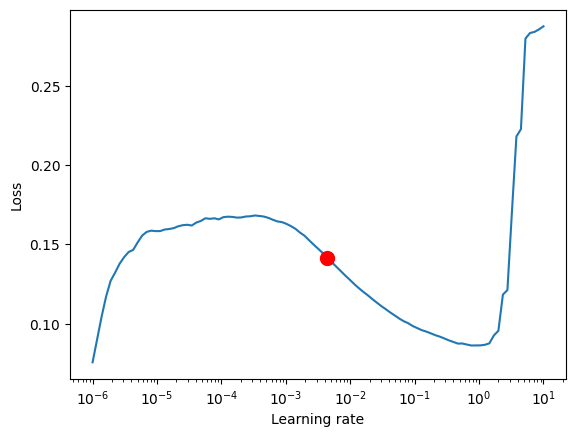

In [34]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [35]:
res.suggestion()

0.004365158322401661

Para el TemporalFusionTransformer, la tasa de aprendizaje óptima es superior a la sugerida.

A veces, no queremos utilizar directamente la tasa de aprendizaje sugerida porque PyTorch Lightning a veces puede confundirse por el ruido a tasas de aprendizaje más bajas y sugiere tasas demasiado bajas.

El control manual es esencial.

De todas maneras la tasa calculada se encuentra de valores conocidos, por lo tanto la usaremos

In [36]:
LR = res.suggestion()

In [37]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=20,
    #accelerator='gpu',   #Descomentar si hay GPU disponible
    #devices=1,           #Descomentar si hay GPU disponible
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [38]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 27.1k


In [39]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 207   
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.5 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Vamos a realizar un tunning de hiperparámetros:

In [40]:
# create study for hyperameter optimization
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=2,
    max_epochs=5,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("./drive/MyDrive/Data/SNFC/Datatest_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

[I 2024-02-22 02:11:25,967] A new study created in memory with name: no-name-95ffca49-b86e-4778-9db9-dac75a9d0fc4
<ipython-input-3-7e0b121f3e00>:121: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-3-7e0b121f3e00>:145: FutureWarning: suggest_un

Veamos cuales son los hiperparámetros óptimos:

In [41]:
# show best hyperparameters
print(study.best_trial.params)

{'gradient_clip_val': 0.351750851190364, 'hidden_size': 120, 'dropout': 0.2707984266586686, 'hidden_continuous_size': 46, 'attention_head_size': 1, 'learning_rate': 0.0011750026767611615}


In [42]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [43]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [44]:
# Calculate mean squared error
mse = mean_squared_error(actuals, baseline_predictions)
# Calculate mean absolute error
mae = mean_absolute_error(actuals, baseline_predictions)

In [45]:
print(f"Mean squared error: {mse}")
print(f"Mean absolute error: {mae}")

Mean squared error: 0.0032577598467469215
Mean absolute error: 0.04074231907725334


Vamos a realizar predicciones:

Después del entrenamiento, podemos hacer predicciones con predict(). El método permite un control muy fino sobre lo que devuelve, de modo que, por ejemplo, puede hacer coincidir fácilmente las predicciones con su marco de datos de pandas. Evaluamos las métricas en el conjunto de datos de validación y en un par de ejemplos para ver lo bien que funciona el modelo.

In [46]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:105: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([32, 30, 1, 44]). Returning list instead of torch.Tensor.
  warnings.warn(


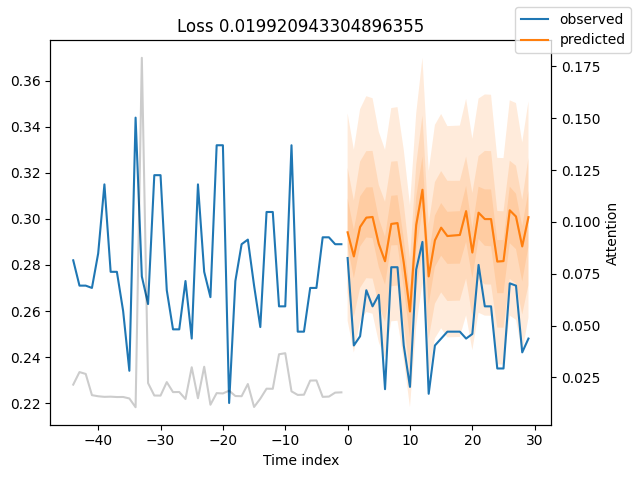

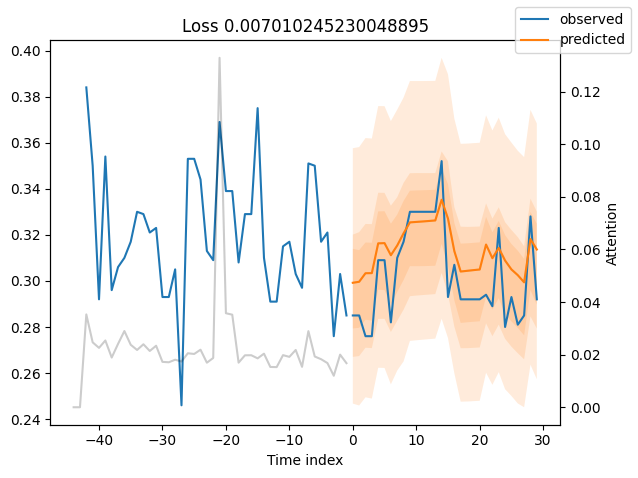

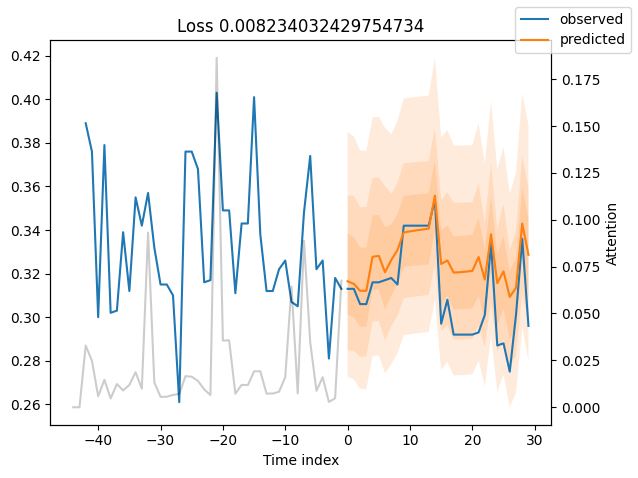

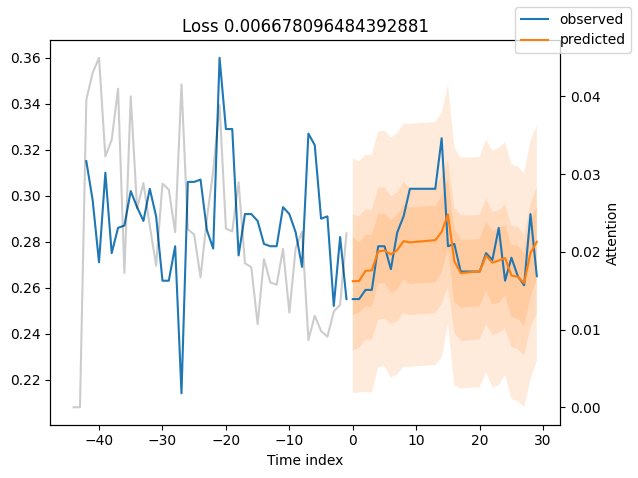

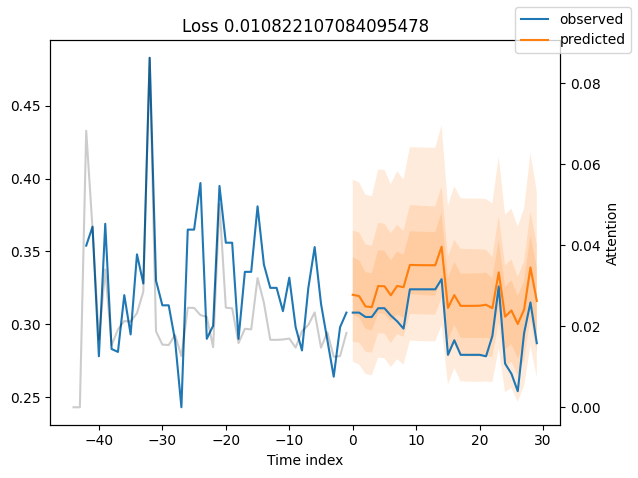

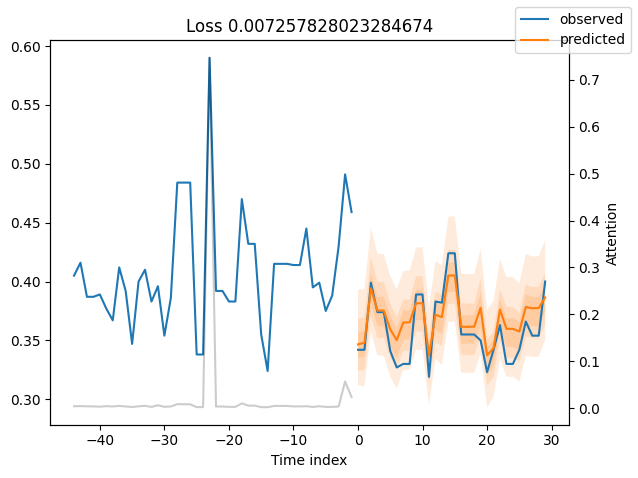

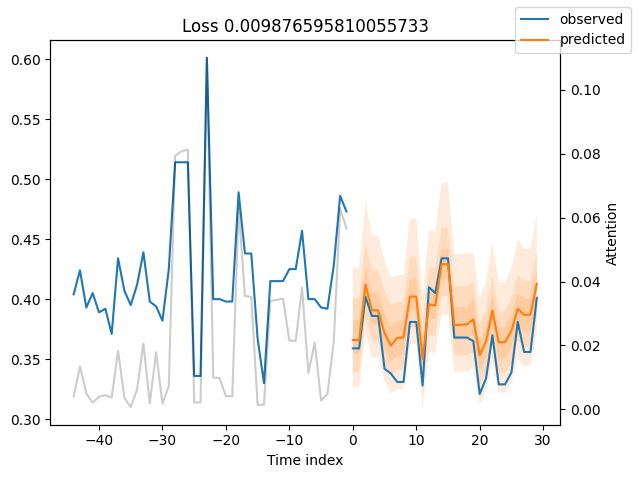

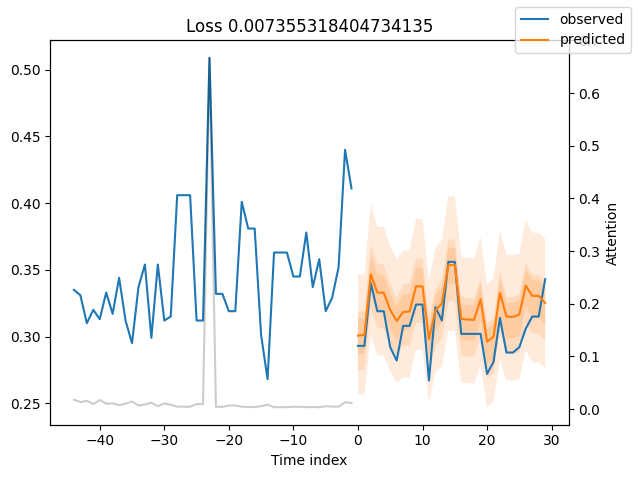

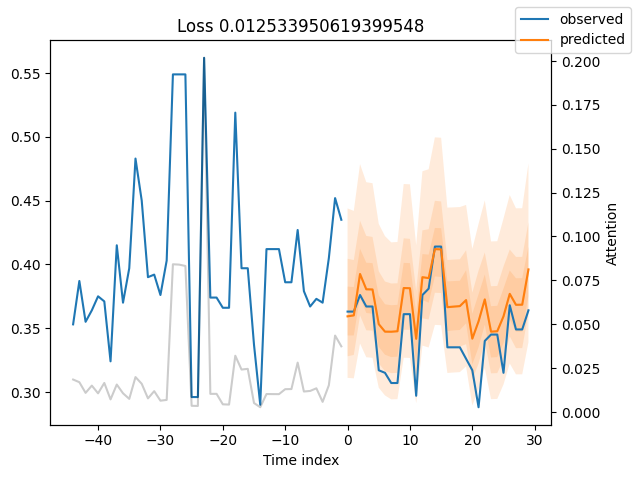

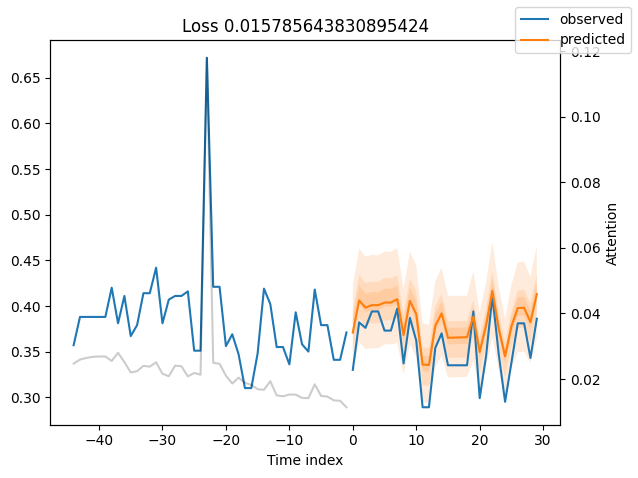

In [47]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

Comprobar cómo se comporta el modelo en distintos segmentos de datos nos permite detectar puntos débiles. Ahora podemos predecir directamente sobre los datos generados utilizando los métodos calculate_prediction_actual_by_variable() y plot_prediction_actual_by_variable(). Las barras grises denotan la frecuencia de la variable por bin, es decir, son un histograma.

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


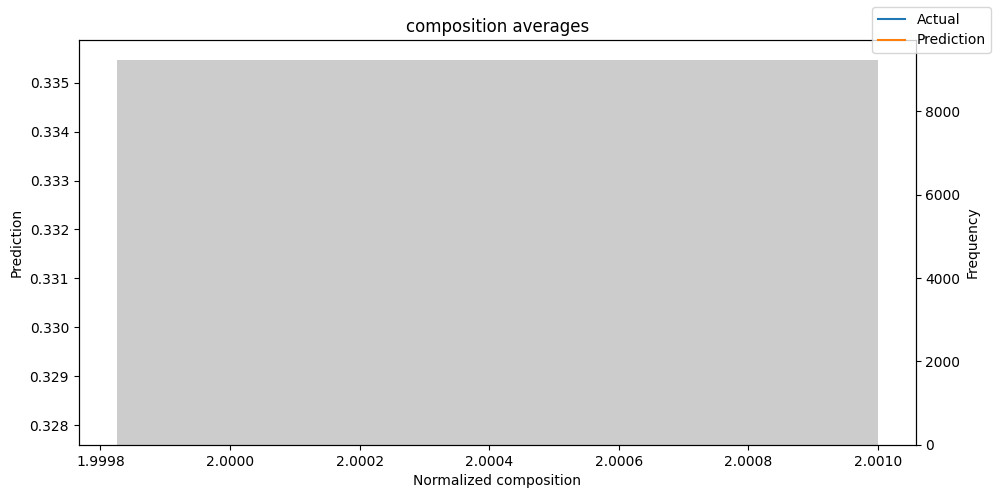

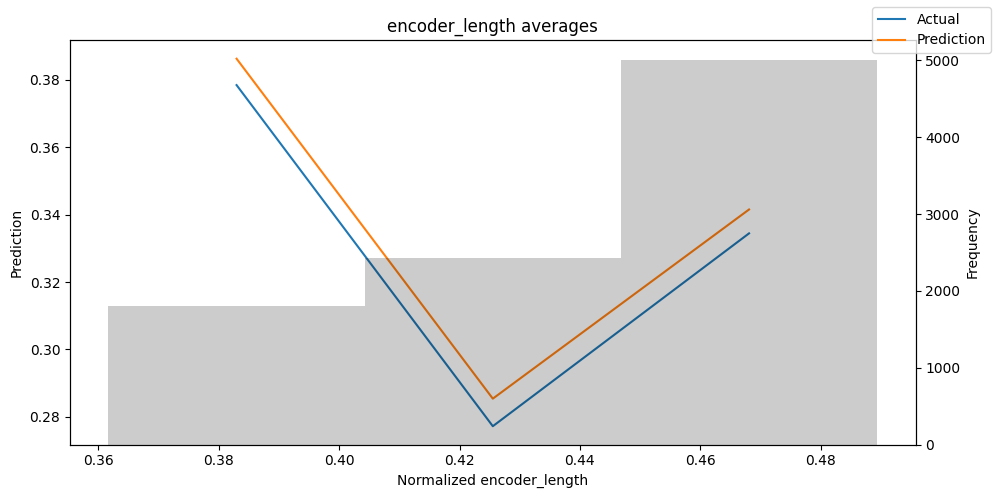

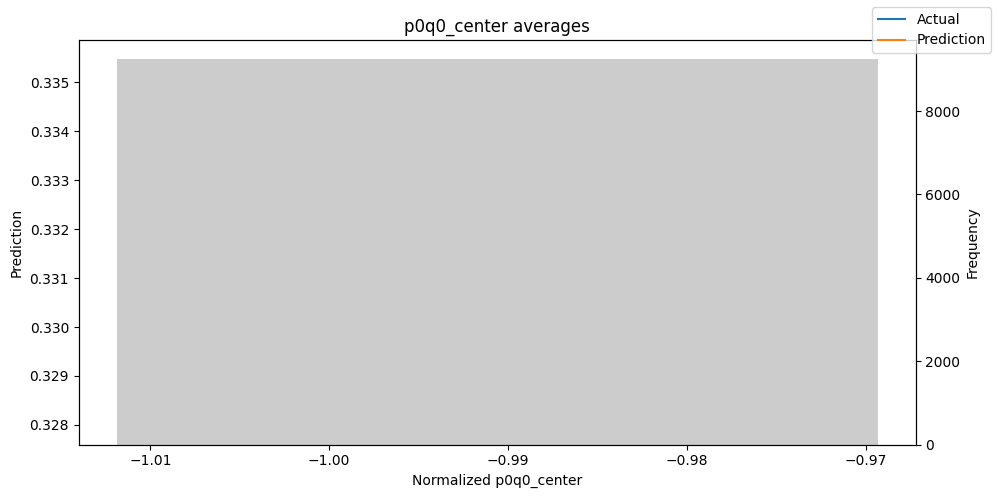

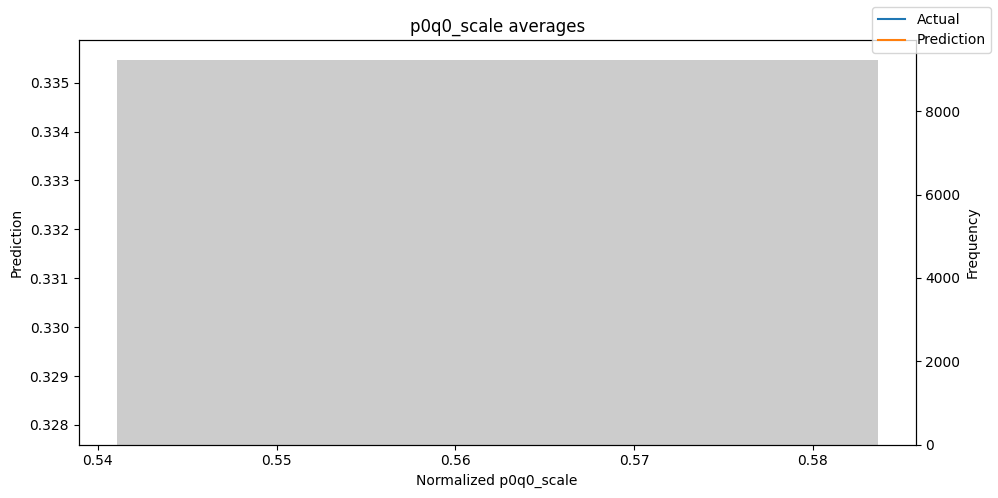

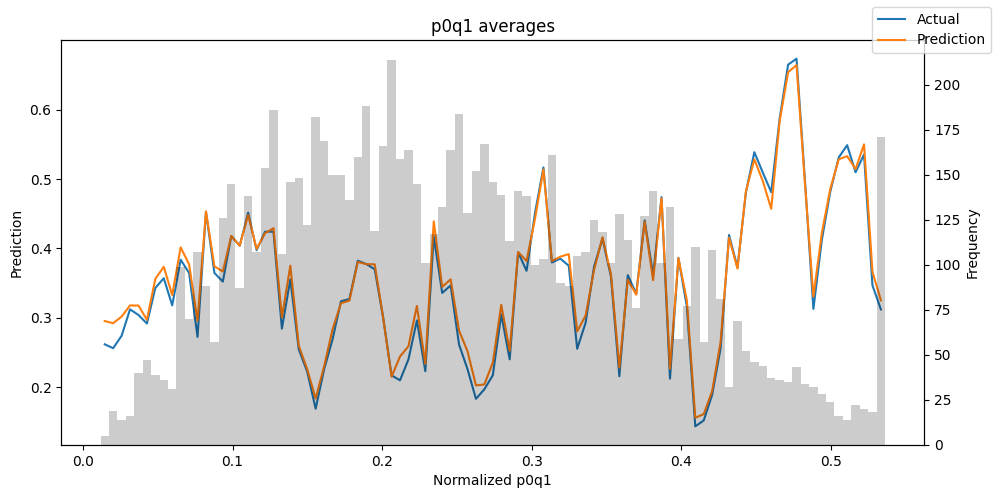

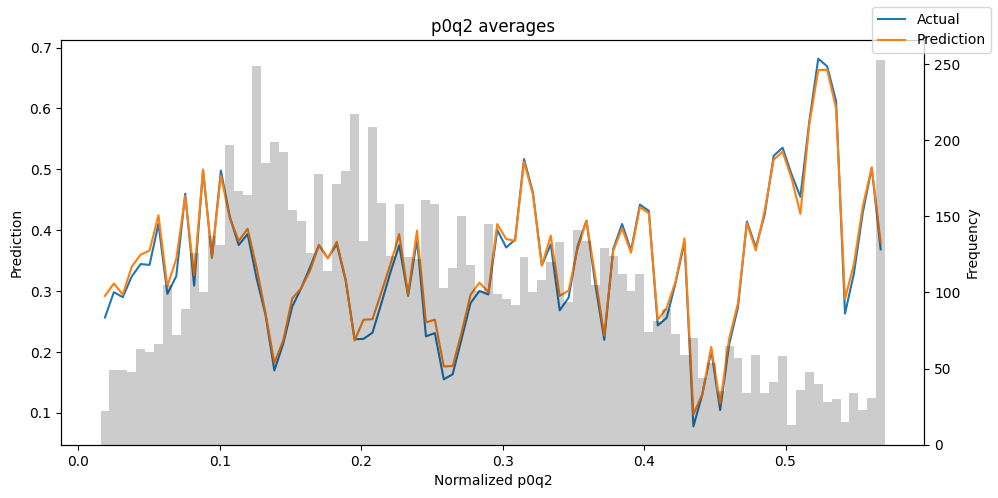

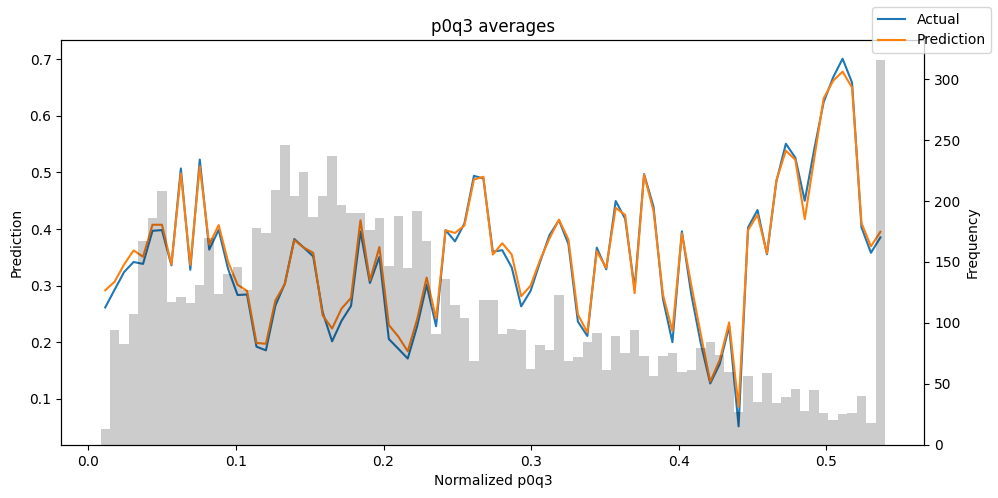

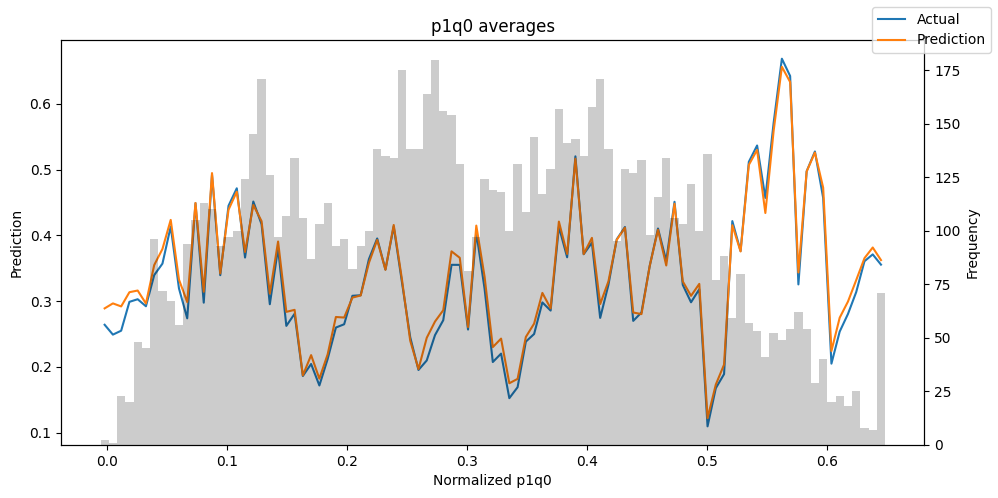

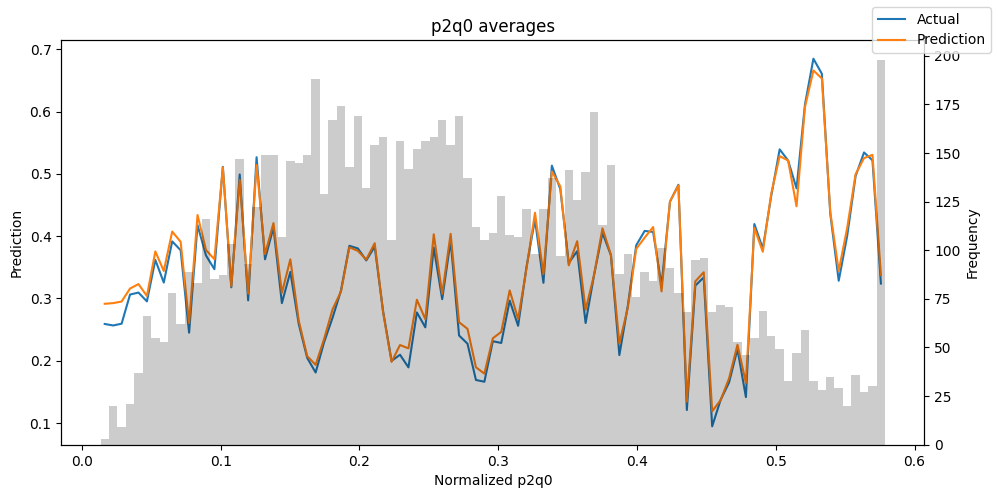

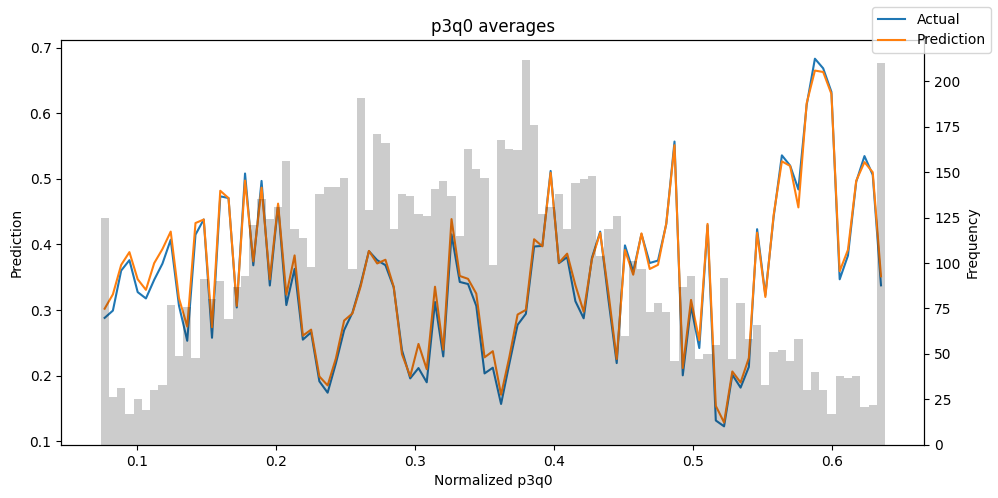

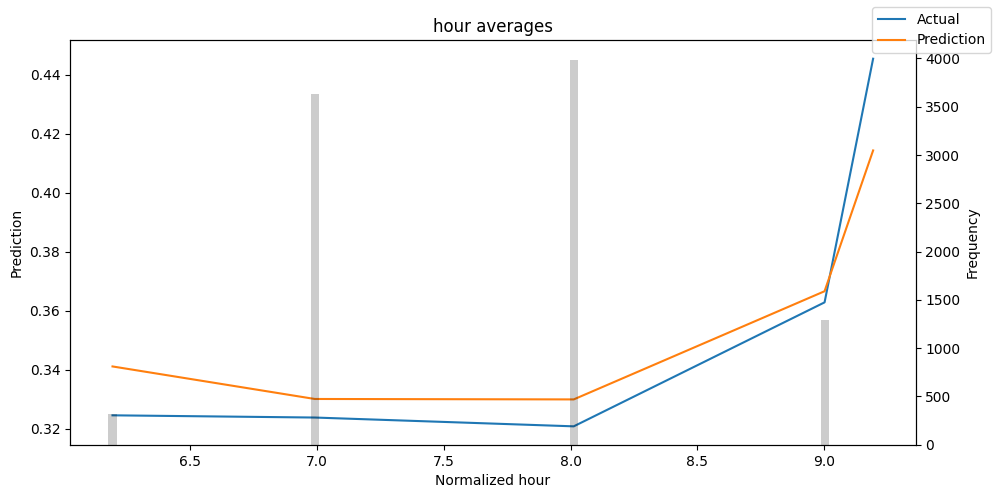

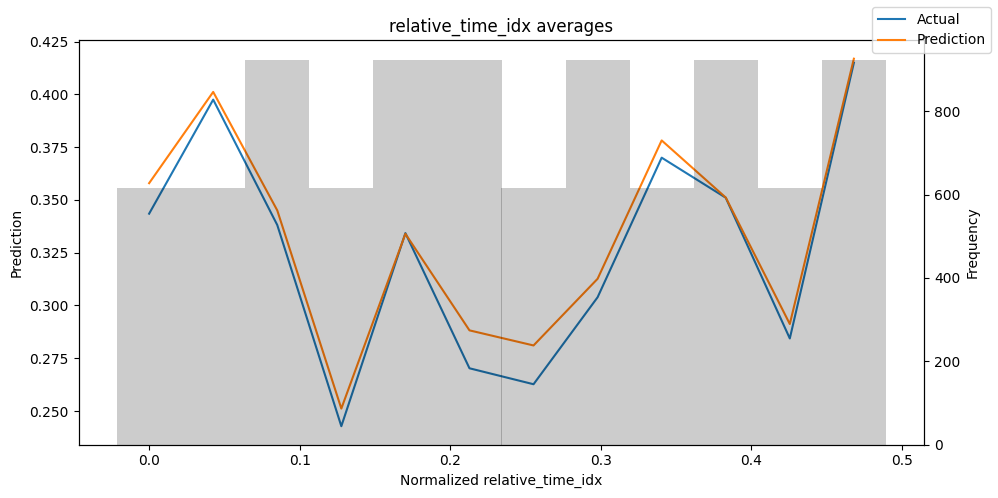

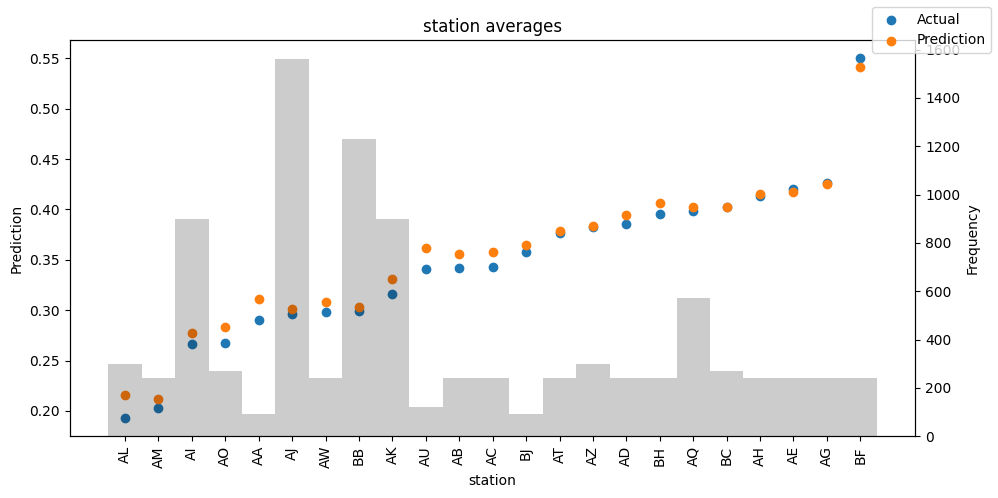

In [48]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)
plt.show()

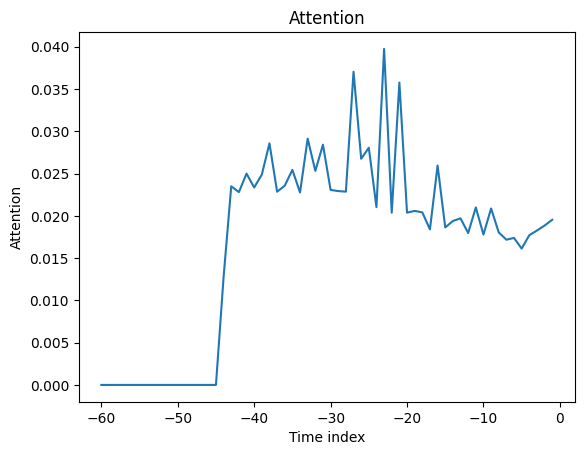

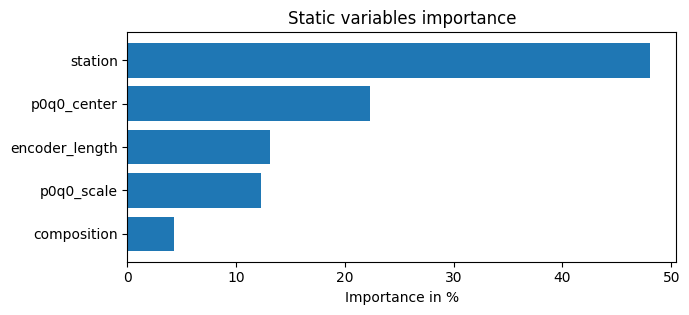

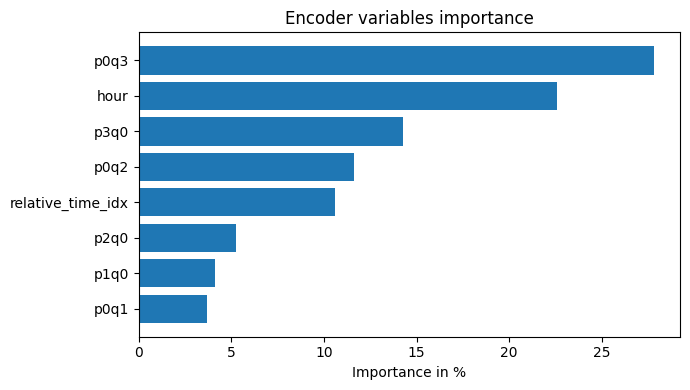

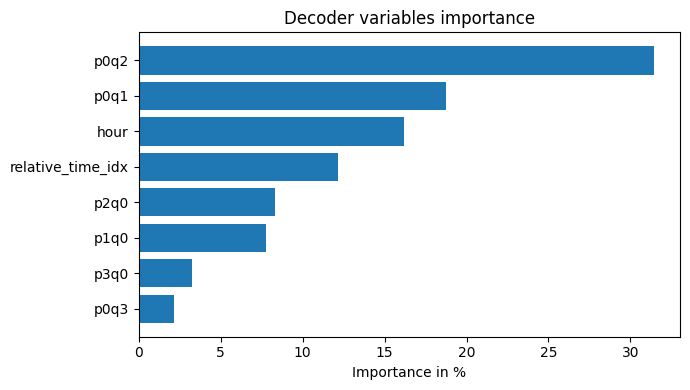

In [49]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)
plt.show()

Referencias:

* Introducing PyTorch Forecasting: https://towardsdatascience.com/introducing-pytorch-forecasting-64de99b9ef46

* Demand forecasting with the Temporal Fusion Transformer: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html#Hyperparameter-tuning